In [1]:
# Import aller benötigten Module

# Eigene Module
import DataGenerationRadar1D as gen_1D
from DataGenerationRadar3D import *
from DBScan import *
from KalmanFilter import KalmanFilter
from ui import interactive1DExperiment, interactiveDBScan, interactive3DExperiment

# Externe Module
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from collections import deque
from ipywidgets import *
from collections import deque
%matplotlib widget
plt.style.use('classic')

# Projektlabor Maschinelles Lernen (PML)
**Präsentation: Gruppe 7**\
\
Domenic Gosein, Lukas Burger, Maximilian Kürschner, Christian Singer\
Informationstechnik\
25.02.2022\
\
<img src="design/hsma_logo.png" alt="logo" width="400"/>

## Agenda Überblick
1. Einleitung 
    1. Der 𝛼-𝛽 Filter und Kalman Gain
2. Das Kalman-Filter 
    1. dynamische H-Matrix
    2. MSE (Metrik) und was wir damit erreicht haben
    3. Transitionsmodell, R-  und Q-Matrix
    4. Interaktiver Plot 1D Experiment
3. 3D Radarsensor Experiment
    1. Kalman-Filter ohne DB-Scan
    2. Kalman-Filter mit DB-Scan (MSE Verbesserung)
4. Schlussfolgerung & Ausblick
5. Fragen & Diskussion

## Theorie: Kalman-Gain und a-b-Filter
* a-b Filter ist simpelste Art von Filter
* Das Verhältnis, in dem Messung und Modell zur Vorhersage beitragen, ist beim a-b-Filter fix
* Beim Kalman Filter wird diese Gewichtung dynamisch durch Kalman-Gain bestimmt
![abFilter](figs/abFilter.png)

## Praxis: Dynamische Auswahl der H-Matrix
* Problem:  Eventuell nicht immer alle Sensormessungen verfügbar
* Lösung:   Statte Filter mit von der Messung abhängigen Versionen der H Matrix aus
* Beispiel: Filter bekommt entweder nur Position oder auch Geschwindigkeit als extra Input

In [2]:
    # Kalman-Filter Algorithmus
    def step(self, z):
        # if only positions are to be predicted by the Kalman-Filter.
        if z.shape[0] == 1:
            H = np.array([self.H[0]])
        # if velocity should be predicted as well.
        else:
            H = self.H

## Theorie: Mean Squared Error (MSE)
* MSE ist eine Metrik zur Messung der Distanz zwischen zwei Pfaden
$$
MSE = \frac{1}{n}\sum_{i=1}^n(Y_{i}-\hat{Y}_{i})^2
$$
* Ermöglicht quantitativen Vergleich von Vorhersage und eigentlichem Pfad

## Theorie: R-Matrix
* Messfehler sind uniform verteilt
* R-Matrix beschreibt die Varianz der Sensormessungen
* Die Varianz einer uniform verteilten Zufallsvariable beträgt
$$
\frac{1}{12}(b-a)^2
$$
* Daher kann R auch mit theoretischer Begründung gewählt werden

## Theorie: Q-Matrix:

- Beinhaltet unmodellierte Dynamiken und Parameterunsicherheiten
- $Q$-Matrix von null verschiedenen $\rightarrow$ Bessere Konvergenzeigenschaften
- Hohes $Q$ $\rightarrow$ Verrauschten Messungen werden höher gewichtet 
- Niedriges $Q$ $\rightarrow$ Bessere Schätzgenauigkeit, weicht jedoch von der tatsächlichen Lösung ab

$\Rightarrow$ Systematische Anpassung der $Q$-Matrix

## Theorie: Transitionsmodell:

Berechnung folgt dem **Weg-Zeit Gesetz**
* Beschleunigung: $a = const$
* Geschwingkeits-Zeit-Gesetz: $v(t) = \dot{s}(t) = at + v_0$
* Weg-Zeit Gesetz: $s(t) = \frac{a}{2}t^2 + v_0t +s_0$

$$
\begin{aligned}
&\begin{array}{lll}
s[k]=s[k-1]+&v[k-1]*dt & +a[k-1]*\frac{1}{2}*dt^2 \\
v[k]=       &v[k-1]    & +a[k-1]*dt\\
a[k]=       &          & +a[k-1]*dt\\
\end{array}
\end{aligned}
$$


Die zeitliche Entwicklung des Zustandsvektors kann mit einem lineares
Gleichungssystem beschrieben werden. Dabei gilt $dt = \frac{1}{measurementRate}$.
```python
dt = 1 / gen_1D.measurementRate # default: measurementRate = 100 Hz
transition_model = np.array([[1, dt, dt**2/2],
                            [0,   1, dt  ],
                            [0,   0, dt ]])
```

## Praxis: 1D-Experiment

Output()

Output()

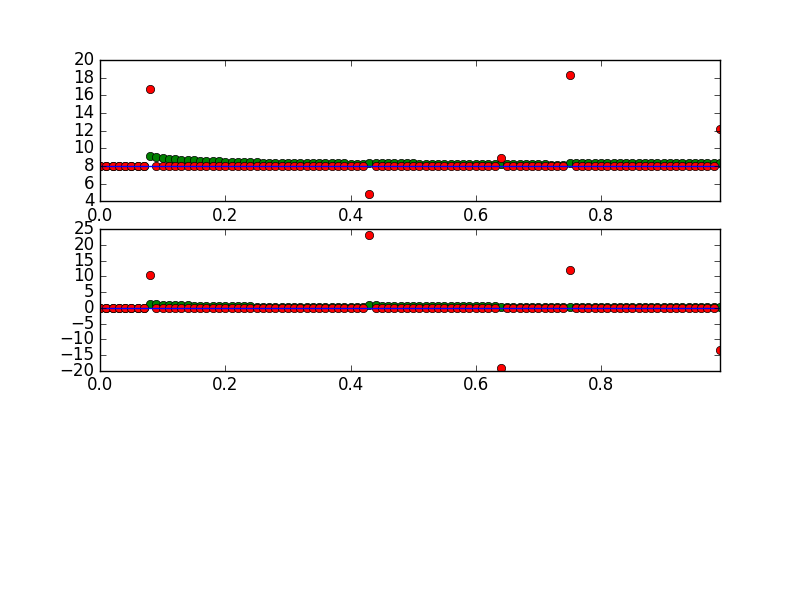

In [3]:
interactive1DExperiment.plot_interactive_kalaman_filter()

## 3D-Experiment Theorie und Praxis
### Theorie: Initialisierung Kalman-Filter

* Transitionsmodell (gleichbleibend):       $$
                                            \begin{pmatrix}
                                            1 & 0.01 & 0.01/2 \\
                                            0 & 1 & 0.01 \\
                                            0 & 0 & 0.01 \\
                                            \end{pmatrix}
                                            $$  
* Q-Matrix (zu Beginn mit hohem Wert):      $$
                                            \begin{pmatrix}
                                            0.5 & 0 & 0 \\
                                            0 & 0.5 & 0 \\
                                            0 & 0 & 0.5 \\
                                            \end{pmatrix}
                                            $$  
* R-Matrix (wobei $\sigma = rangeAccuracy$):$$
                                            \frac{\sigma^2}{3}
                                            $$  
* H-Matrix (mit Position):           $$
                                            \begin{pmatrix}
                                            1 & 0 & 0 \\
                                            \end{pmatrix}
                                            $$

Domenic Notizen:
* Unser Kalman Filter ist so gebaut, dass wir ihn auch für den 3D Fall verwenden können
* Zunächst initialisieren wir das Kalman Filter
    * dabei bleibt unser Transitionsmodell, wie bereits von Lukas erklärt, gleich
    * die Q-Matrix initialisieren wir zunächst mit einem hohen Wert
    * die R-Matrix mit sigma quadrat geteilt durch drei, wobei sigma gleich range Accurany des Sensors, wie bereits von Christian eingangs erklärt
    * Die H-Matrix initialisieren wir so, damit sie die Positon berücksichtigt

### Praxis: 3D Kalman Filter ohne DBScan

In [4]:
def show_plot_slide():
    
    path = [[0,5,0],
        [0,5,0.5],
        [1,5,1],
        [1,5,0.5],
        [0.5, 2, 0.1]]

    vel = 3 * numpy.ones((1,5))
    vel[0,2] = 1

    InitialPosition = numpy.array([-1,5,0])

    opt = {
        'InitialPosition' : InitialPosition,
        'Path' : numpy.array(path).transpose(),
        'Velocities' : vel
    }

    x = Target(opt)

    targets = [x]

    # Initialisierung benötigter Variablen
    Detections = np.array([0,0,0,0])
    i = 0
    pred = []

    getNext = True
    while(getNext == True):

        for target in targets:
            target.Step(1/sensor.opt['MeasurementRate'])
            getNext = getNext & ~target.reachedEnd  

        dets = sensor.Detect(targets)
        for det in dets:
            Detections = np.vstack((det, Detections))

        s0 = np.vstack((Detections[0,:-1], np.zeros((2,3))))

        if i == 0:
            f = KalmanFilter(s0, transition_model, H, Q, R)
            pred.append(s0[0,:])

        s = Detections[0,:-1].reshape(1,3)
        s_hat = f.step(s)
        pred = np.vstack((s_hat[0,:], pred))
        i += 1

    T1 = pred[:-1]
    
    fig = plt.figure(figsize=(8, 4),facecolor='w')
    ax1 = fig.add_subplot(121, projection='3d')   
    ax2 = fig.add_subplot(122, projection='3d')
    ax1.plot3D(T1[:,0], T1[:,1], T1[:,2], 'bo')
    ax2.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'r*')
    
    fig = plt.figure(facecolor='w')
    ax = plt.axes(projection='3d')
    ax.plot3D(T1[:,0], T1[:,1], T1[:,2], 'bo')
    ax.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'r*')

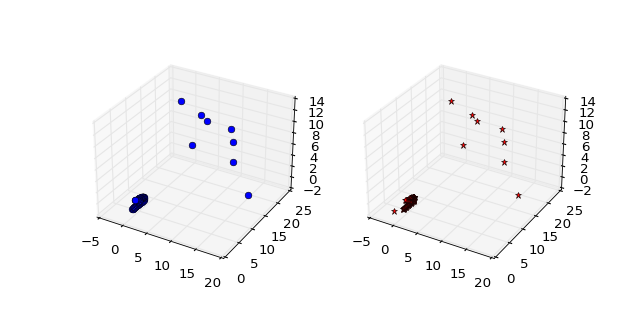

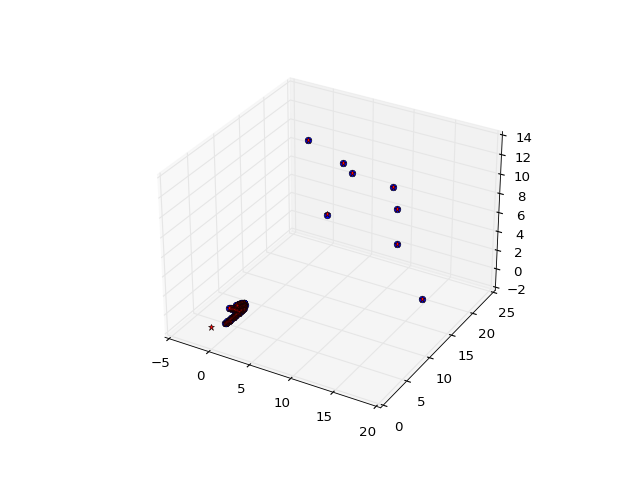

In [7]:
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1,    0.01  ],
                             [0, 0,    0.01 ]])
Q = np.diag([0.5, 0.5, 0.5])
#Q = np.diag([0.002, 0.002, 0.002])
R = np.diag([rangeAccuracy**2])/3
#R = np.diag([0.05])
H =  np.array([[1, 0, 0]])
optRadar = {
    'Position' : numpy.array([0,0,0.5]),
    'OpeningAngle' : numpy.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True,
    'falseDetectionsRange' : 10 # neuer Parameter für Range
}
sensor = RadarSensor(optRadar)
show_plot_slide()

Domenic Notizen:
* Um zu sehen wir das Kalman Filter alleine auf viele bzw. wenig Aureißer reagiert, haben wir an dieser Stelle zusätzlich einen Plot eingefügt, in dem wir dies sehen
* Wir sehen, dass mit dem hohen Porzessrauschen über die Q-Matrix die blauen Punkte, also die Vorhersagen des Kalman Filter nahe an den Detections des Radarsensors liegen - dies ist also keine besonders gute Initialisierung für die Q-Matrix
* Reduzieren wir den Wert nun auf einen sehr kleinen Wert von 0.002, also wenig Prozessrauschen, sehen wir die Vorhersagen des Kalman Filter Rücken näher an den eigentlichen Pfad
* Um den Effekt weiter zu verdeutlichen können wir nun noch die R-Matrix bzw. das Messrauschen erhöhen auf 0.5 und schenken so den Vorhersagen des Kalman Filter mehr vertrauen - das Resultat ist, die blauen Punkte rücken noch näher an den Pfad
* Das Kalman Filter ist durch diese Eintellungen also weniger von den Ausreißern betroffen
* und damit übergebe ich an meinen Kollegen Maximilan

## Praxis: 3D Kalman-Filter mit DBScan und MSE Vergleich

Output()

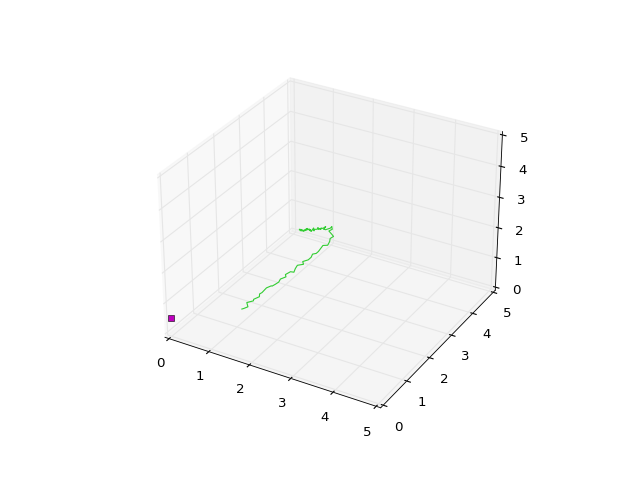

In [6]:
interactive3DExperiment.plot_3DExperiment()

## Schlussfolgerungen aus den Experimenten
* Enmorme Verbesserungen im Vergleich zu reinen Sensordaten im 1D-Fall
* Verbesserungen bei steigendem Messfehler im 3D-Fall spürbar
* Sinvolle Positionsvorhersagen mittels DBScan möglich
* Berücksichtigung der Radialgeschwindigkeit durch Approximieren

Domenic Notizen:
* Unsere Implementation des Kalman-Filters liefert enorme Verbesserungen im Vergleich zu den reinen Sensormessdaten im eindimensionalen Fall
* Im dreidimensionalen Fall sind die Verbesserungen bei steigendem Messfehler des Sensors zumindest spürbar, wenn auch definitiv weniger stark als im eindimensionalen Fall
* Die Kombination des Kalman-Filters mit dem DBSCAN Algorithmus eröffnet die Möglichkeiten auch bei starkem Messrauschen noch sinnvolle Positionsvorhersagen zu liefern
* Da sich aus dieser eindimensionalen Größe nicht unmittelbar der dreidimensionale Geschwindigkeitsvektor berechnen lässt wurde versucht die vorletzte Messung des Sensors heranzuziehen um somit den wahren Geschwindigkeitsvektor zu approximieren

## Ausblick
* Einbinden von weiter zurückliegenden Observationen durch s. g. *smoothing*
* Test mit echten Sensordaten sowie Verbesserung und Weiterentwicklung

Domenic Notizen:
* Da das Kalman-Filter bei der Vorhersage des nächsten Zustands jeweils nur die letzte Observation direkt in Betracht zieht könnte es sich anbieten auch weiter zurückliegende Observationen mit in Betracht zu ziehen
* Des Weiteren wäre es nun sinnvoll unsere Implementation mit echten Sensordaten zu testen und sie anschließend weiterzuentwickeln und zu verbessern

## Weiterführende Informationen
* Interaktives Juypter Notebook
* GitHub Repository mit unserem Code und Bericht: https://github.com/otiofrui/pml

*$\Rightarrow$ Link und Zugang auf Anfrage!*

![GitHub Repo](design/github_repo.png)

Domenic Notizen:
* Um die Effekte des Kalman Filter und DBScan besser darzustellen und damit verständlich zu machen, haben wir auf Juypter Notebook zurückgegriffen
* Wir haben einen eigenen Server auf dem unsere Implementation getestet werden kann
* Unser Code und Bericht liegt in einem GitHub Repository
* Falls ihr selbst ausprobieren wollt, können wir euch auf Anfrage den Zugang für beides freischalten
* Und damit sind wir am Ende unserer Präsentation und starten in die Fragen und Diskussionsrunde

## Fragen & Diskussion
![Conversation Icon](design/conversation.png)